This notebook provides examples to go along with the [textbook](http://manipulation.csail.mit.edu/clutter.html).  I recommend having both windows open, side-by-side!

In [1]:
import numpy as np
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Box,
    ConnectPlanarSceneGraphVisualizer,
    DiagramBuilder,
    FixedOffsetFrame,
    JointIndex,
    Parser,
    PlanarJoint,
    RandomGenerator,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
)

from manipulation import ConfigureParser, running_as_notebook
from manipulation.scenarios import AddShape, ycb
from manipulation.station import LoadScenario, MakeHardwareStation

In [2]:
meshcat = StartMeshcat()
rng = np.random.default_rng(145)  # this is for python
generator = RandomGenerator(rng.integers(0, 1000))  # this is for c++

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Falling things (in 2D)


In [3]:
def clutter_gen():
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)

    # Add the ground.
    ground = AddShape(
        plant, Box(10.0, 10.0, 10.0), "ground", color=[0.9, 0.9, 0.9, 1.0]
    )
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("ground", ground),
        RigidTransform([0, 0, -5]),
    )

    # Add the bricks, each attached to the world via a planar joint.
    parser = Parser(plant)
    ConfigureParser(parser)
    planar_joint_frame = plant.AddFrame(
        FixedOffsetFrame(
            "planar_joint_frame",
            plant.world_frame(),
            RigidTransform(RotationMatrix.MakeXRotation(np.pi / 2)),
        )
    )
    for i in range(20 if running_as_notebook else 2):
        directives = f"""
directives:
- add_model:
    name: object{i}
    file: package://manipulation/hydro/061_foam_brick.sdf
"""
        instance = parser.AddModelsFromString(directives, ".dmd.yaml")[0]
        plant.AddJoint(
            PlanarJoint(
                f"joint{i}",
                planar_joint_frame,
                plant.GetFrameByName("base_link", instance),
                damping=[0, 0, 0],
            )
        )

    plant.Finalize()

    vis = ConnectPlanarSceneGraphVisualizer(
        builder,
        scene_graph,
        xlim=[-0.6, 0.6],
        ylim=[-0.1, 0.5],
        show=False,
    )

    diagram = builder.Build()
    simulator = Simulator(diagram)
    plant_context = plant.GetMyContextFromRoot(simulator.get_mutable_context())

    z = 0.1
    for i in range(plant.num_joints()):
        joint = plant.get_joint(JointIndex(i))
        if isinstance(joint, PlanarJoint):
            joint.set_pose(
                plant_context,
                [rng.uniform(-0.4, 0.4), z],
                rng.uniform(-np.pi / 2.0, np.pi / 2.0),
            )
            z += 0.1

    vis.start_recording()
    simulator.AdvanceTo(1.5 if running_as_notebook else 0.1)
    vis.stop_recording()
    ani = vis.get_recording_as_animation(repeat=False)
    display(HTML(ani.to_jshtml()))


clutter_gen()

# Falling things (in 3D)

I had to decide how to visualize the results of this one for you. The mesh and
texture map files for the YCB objects are very large, so downloading many of
them to your browser from an online notebook felt a bit too painful. If you've
decided to run the notebooks from source on your local machine, then go ahead
and open meshcat before running this test to see the live simulation. For the
cloud notebooks, I've decided to add a camera to the scene and take a picture
after simulating for a few seconds.  After all, that's perhaps the data that
we're actually looking for.

[Note](https://stackoverflow.com/questions/73873885/meshcat-fails-to-import-png-for-cracker-box-in-drake-planar-force-control-demo) that Drake's pip installation doesn't currently include the texture maps for the YCB objects, because they're too big to fit in the `pip` wheel 100MB limit.

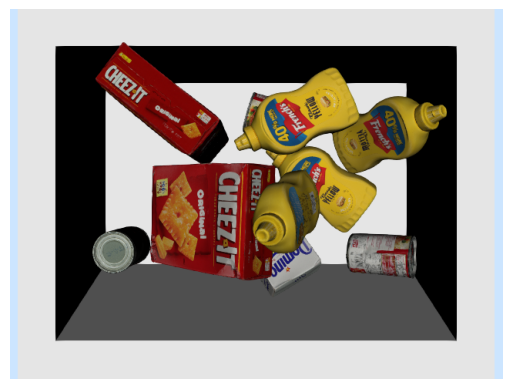

In [4]:
def clutter_gen():
    scenario_data = """
cameras:
    main_camera:
        name: camera0
        depth: True
        X_PB:
            base_frame: world
            translation: [0, 0, 0.8]
            rotation: !Rpy { deg: [180, 0, 90]}
directives:
- add_model:
    name: bin
    file: package://manipulation/hydro/bin.sdf
- add_weld:
    parent: world
    child: bin::bin_base
"""
    for i in range(10 if running_as_notebook else 2):
        object_num = rng.integers(0, len(ycb))
        scenario_data += f"""
- add_model:
    name: thing{i}
    file: package://manipulation/hydro/{ycb[object_num]}
"""
    # TODO(russt): If I didn't need to add the body name, then I could use default_free_body_pose right here and avoid the second loop.

    scenario = LoadScenario(data=scenario_data)
    station = MakeHardwareStation(scenario, meshcat)

    simulator = Simulator(station)
    context = simulator.get_mutable_context()
    plant = station.GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(context)

    z = 0.2
    for body_index in plant.GetFloatingBaseBodies():
        tf = RigidTransform(
            UniformlyRandomRotationMatrix(generator),
            [rng.uniform(-0.15, 0.15), rng.uniform(-0.2, 0.2), z],
        )
        plant.SetFreeBodyPose(plant_context, plant.get_body(body_index), tf)
        z += 0.1

    simulator.AdvanceTo(2.0 if running_as_notebook else 0.1)
    color_image = station.GetOutputPort("camera0.rgb_image").Eval(context)
    plt.figure()
    plt.imshow(color_image.data)
    plt.axis("off")


clutter_gen()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=600b6296-e1a1-4c56-95c9-1a1516f29a41' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>